In [1]:
import os
import cv2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install opencv-python

^C
Note: you may need to restart the kernel to use updated packages.


In [9]:
#Files
path='C:\\Users\\Donia\\Desktop\\Train\\Train'
pd.DataFrame(os.listdir(path),columns=['Files'])

Files
0     0
1     1

In [10]:
train_data_dir =path
batch_size = 32
target_size = (224, 224)
validation_split = 0.3
#test_split = 0.15
train_split = 0.7
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=44,
    image_size=target_size,
    batch_size=batch_size,
)
# test= tf.keras.preprocessing.image_dataset_from_directory(
#     train_data_dir,
#     validation_split=validation_split,
#     subset="validation",
#     seed=44,
#     image_size=target_size,
#     batch_size=batch_size,
# )

Found 12272 files belonging to 2 classes.
Using 8591 files for training.
Found 12272 files belonging to 2 classes.
Using 3681 files for validation.


In [11]:
class_names = train.class_names
class_names

['0', '1']

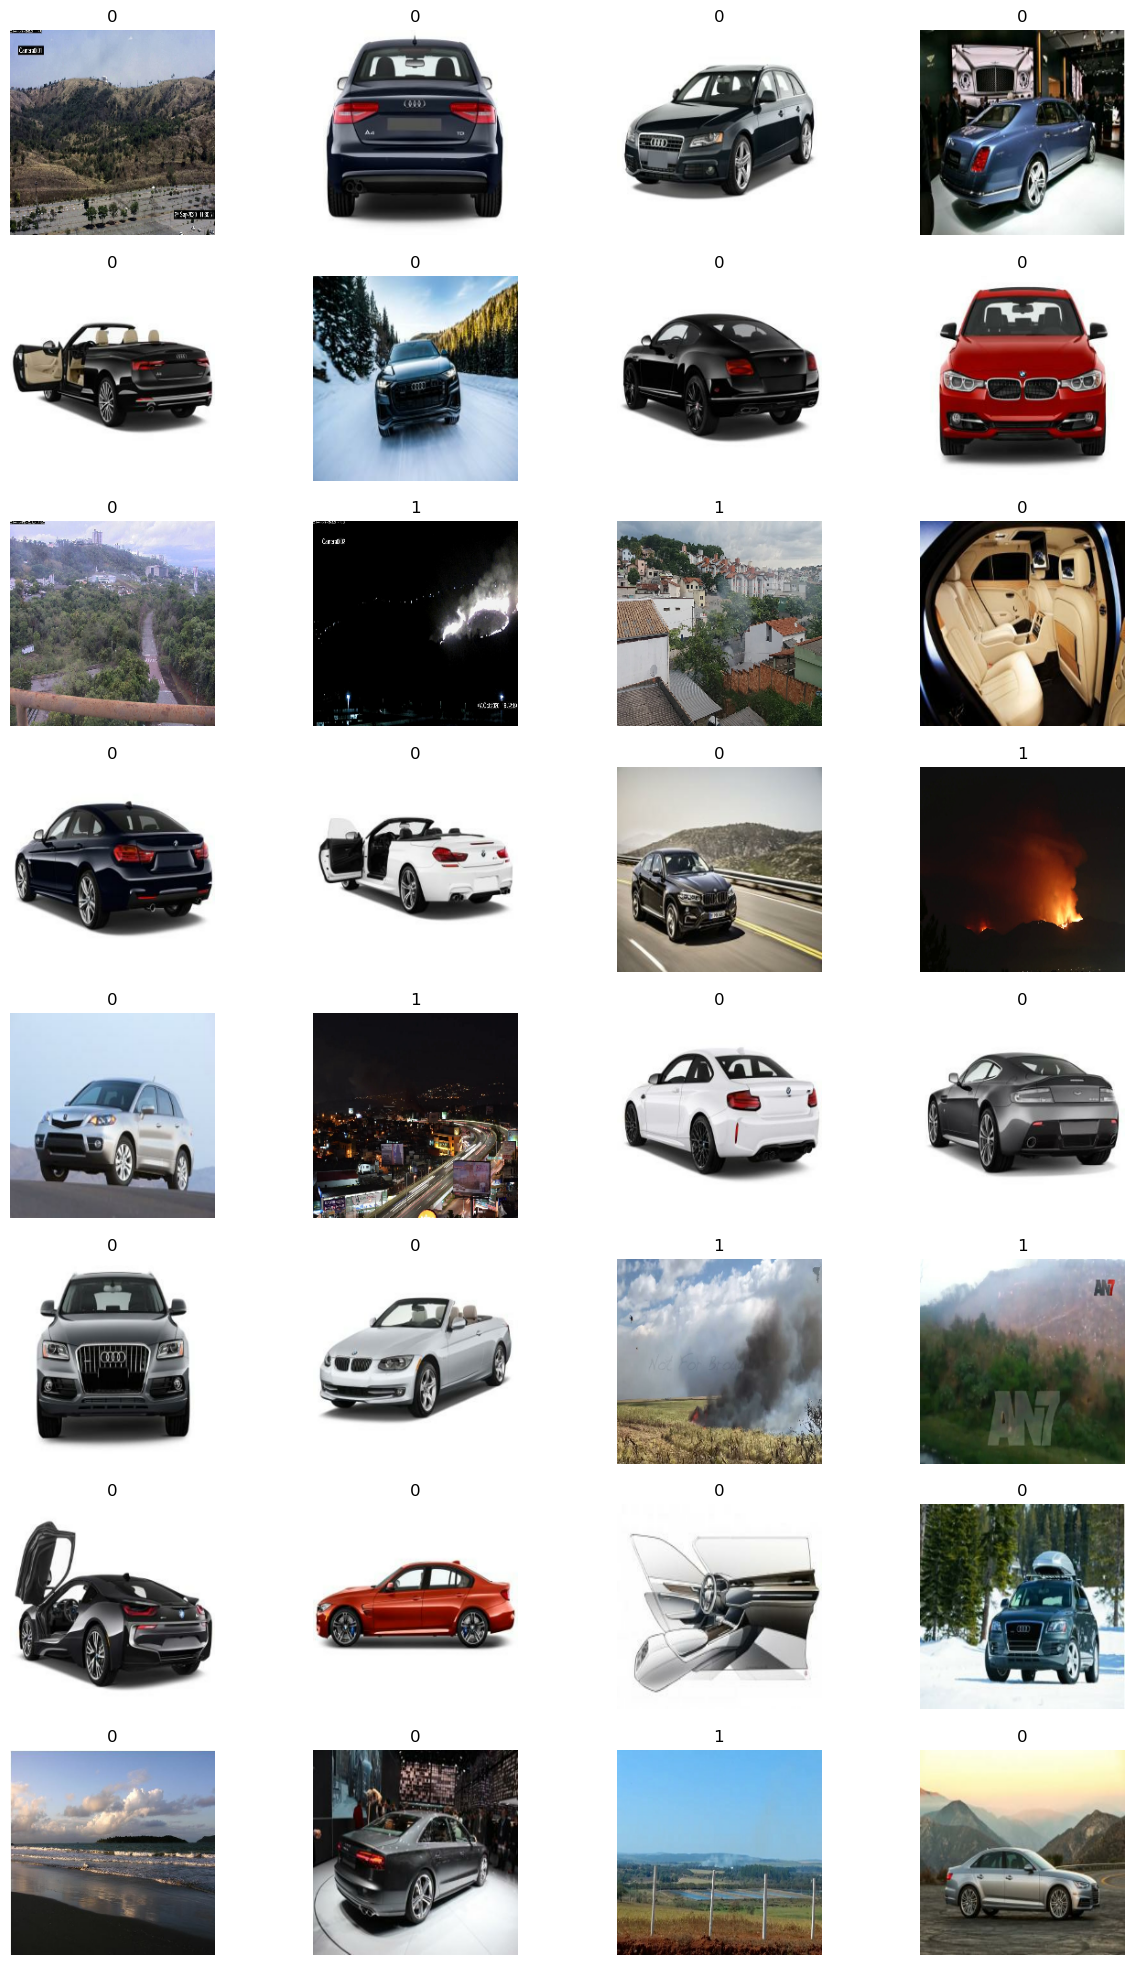

In [12]:
plt.figure(figsize=(15, 25))
for images, labels in train.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
model=keras.models.Sequential()
model.add(base_model)
model.add(keras.layers.Flatten()) 
model.add(keras.layers.Dropout(.2))
model.add(keras.layers.Dense(1,activation=tf.nn.sigmoid))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [14]:
checkpoint_cb =ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=3, restore_best_weights=True)
model.compile(optimizer ='adam',loss='binary_crossentropy', metrics=['accuracy'])
hist=model.fit_generator(train,epochs=100,validation_data=validation,callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/100
269/269 [==============================] - 1297s 5s/step - loss: 1.0702 - accuracy: 0.9296 - val_loss: 0.5951 - val_accuracy: 0.9655
Epoch 2/100
269/269 [==============================] - 1333s 5s/step - loss: 0.4124 - accuracy: 0.9717 - val_loss: 0.5554 - val_accuracy: 0.9731
Epoch 3/100
269/269 [==============================] - 1345s 5s/step - loss: 0.2892 - accuracy: 0.9803 - val_loss: 0.4638 - val_accuracy: 0.9804
Epoch 4/100
269/269 [==============================] - 1343s 5s/step - loss: 0.1436 - accuracy: 0.9878 - val_loss: 0.6397 - val_accuracy: 0.9720
Epoch 5/100
269/269 [==============================] - 1328s 5s/step - loss: 0.1339 - accuracy: 0.9898 - val_loss: 0.6144 - val_accuracy: 0.9777
Epoch 6/100
269/269 [==============================] - 1345s 5s/step - loss: 0.1390 - accuracy: 0.9903 - val_loss: 0.7375 - val_accuracy: 0.9742


In [19]:
# score, acc = model.evaluate(validation)
# print('Test Loss =', score)
# print('Test Accuracy =', acc)
result = model.evaluate(validation)
print('test Loss:', result[0])
print('test Accuracy:', result[1])

116/116 [==============================] - 402s 3s/step - loss: 0.4638 - accuracy: 0.9804
test Loss: 0.46378448605537415
test Accuracy: 0.980440080165863


In [16]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0  1.070196  0.929577  0.595071      0.965499
1  0.412370  0.971715  0.555431      0.973105
2  0.289223  0.980328  0.463784      0.980440
3  0.143613  0.987778  0.639736      0.972018
4  0.133933  0.989757  0.614357      0.977723
5  0.139042  0.990339  0.737469      0.974192

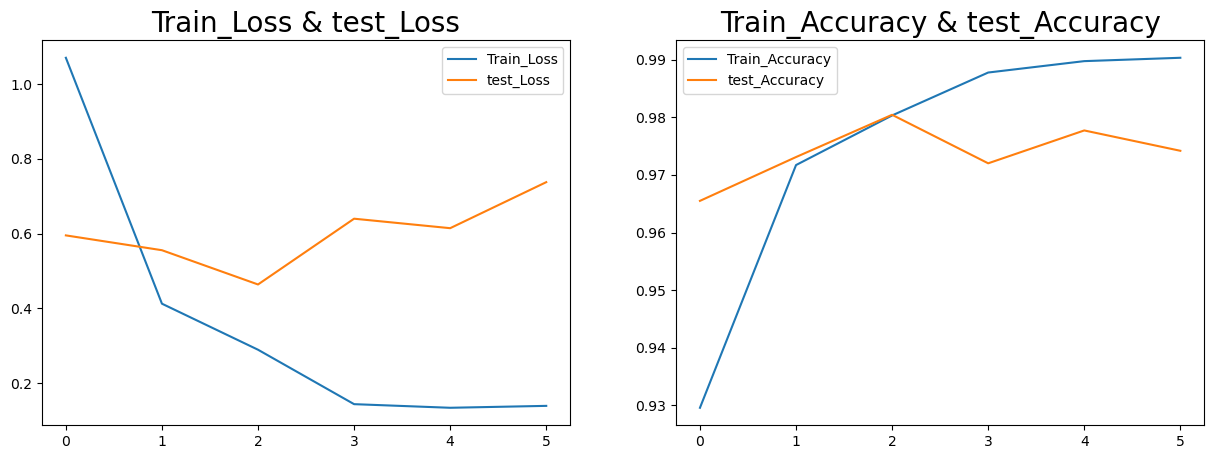

In [22]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='test_Loss')
plt.title('Train_Loss & test_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='test_Accuracy')
plt.title('Train_Accuracy & test_Accuracy',fontsize=20)
plt.legend()

In [23]:
X_val,y_val=[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=model.predict(np.array(X_val))
y_pred=np.where(predictions>=.5,1,0)
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

116/116 [==============================] - 374s 3s/step


Actual  Prediction
0          0           0
1          1           0
2          1           1
3          0           0
4          1           1
...      ...         ...
3676       0           0
3677       1           1
3678       0           0
3679       1           1
3680       0           0

[3681 rows x 2 columns]

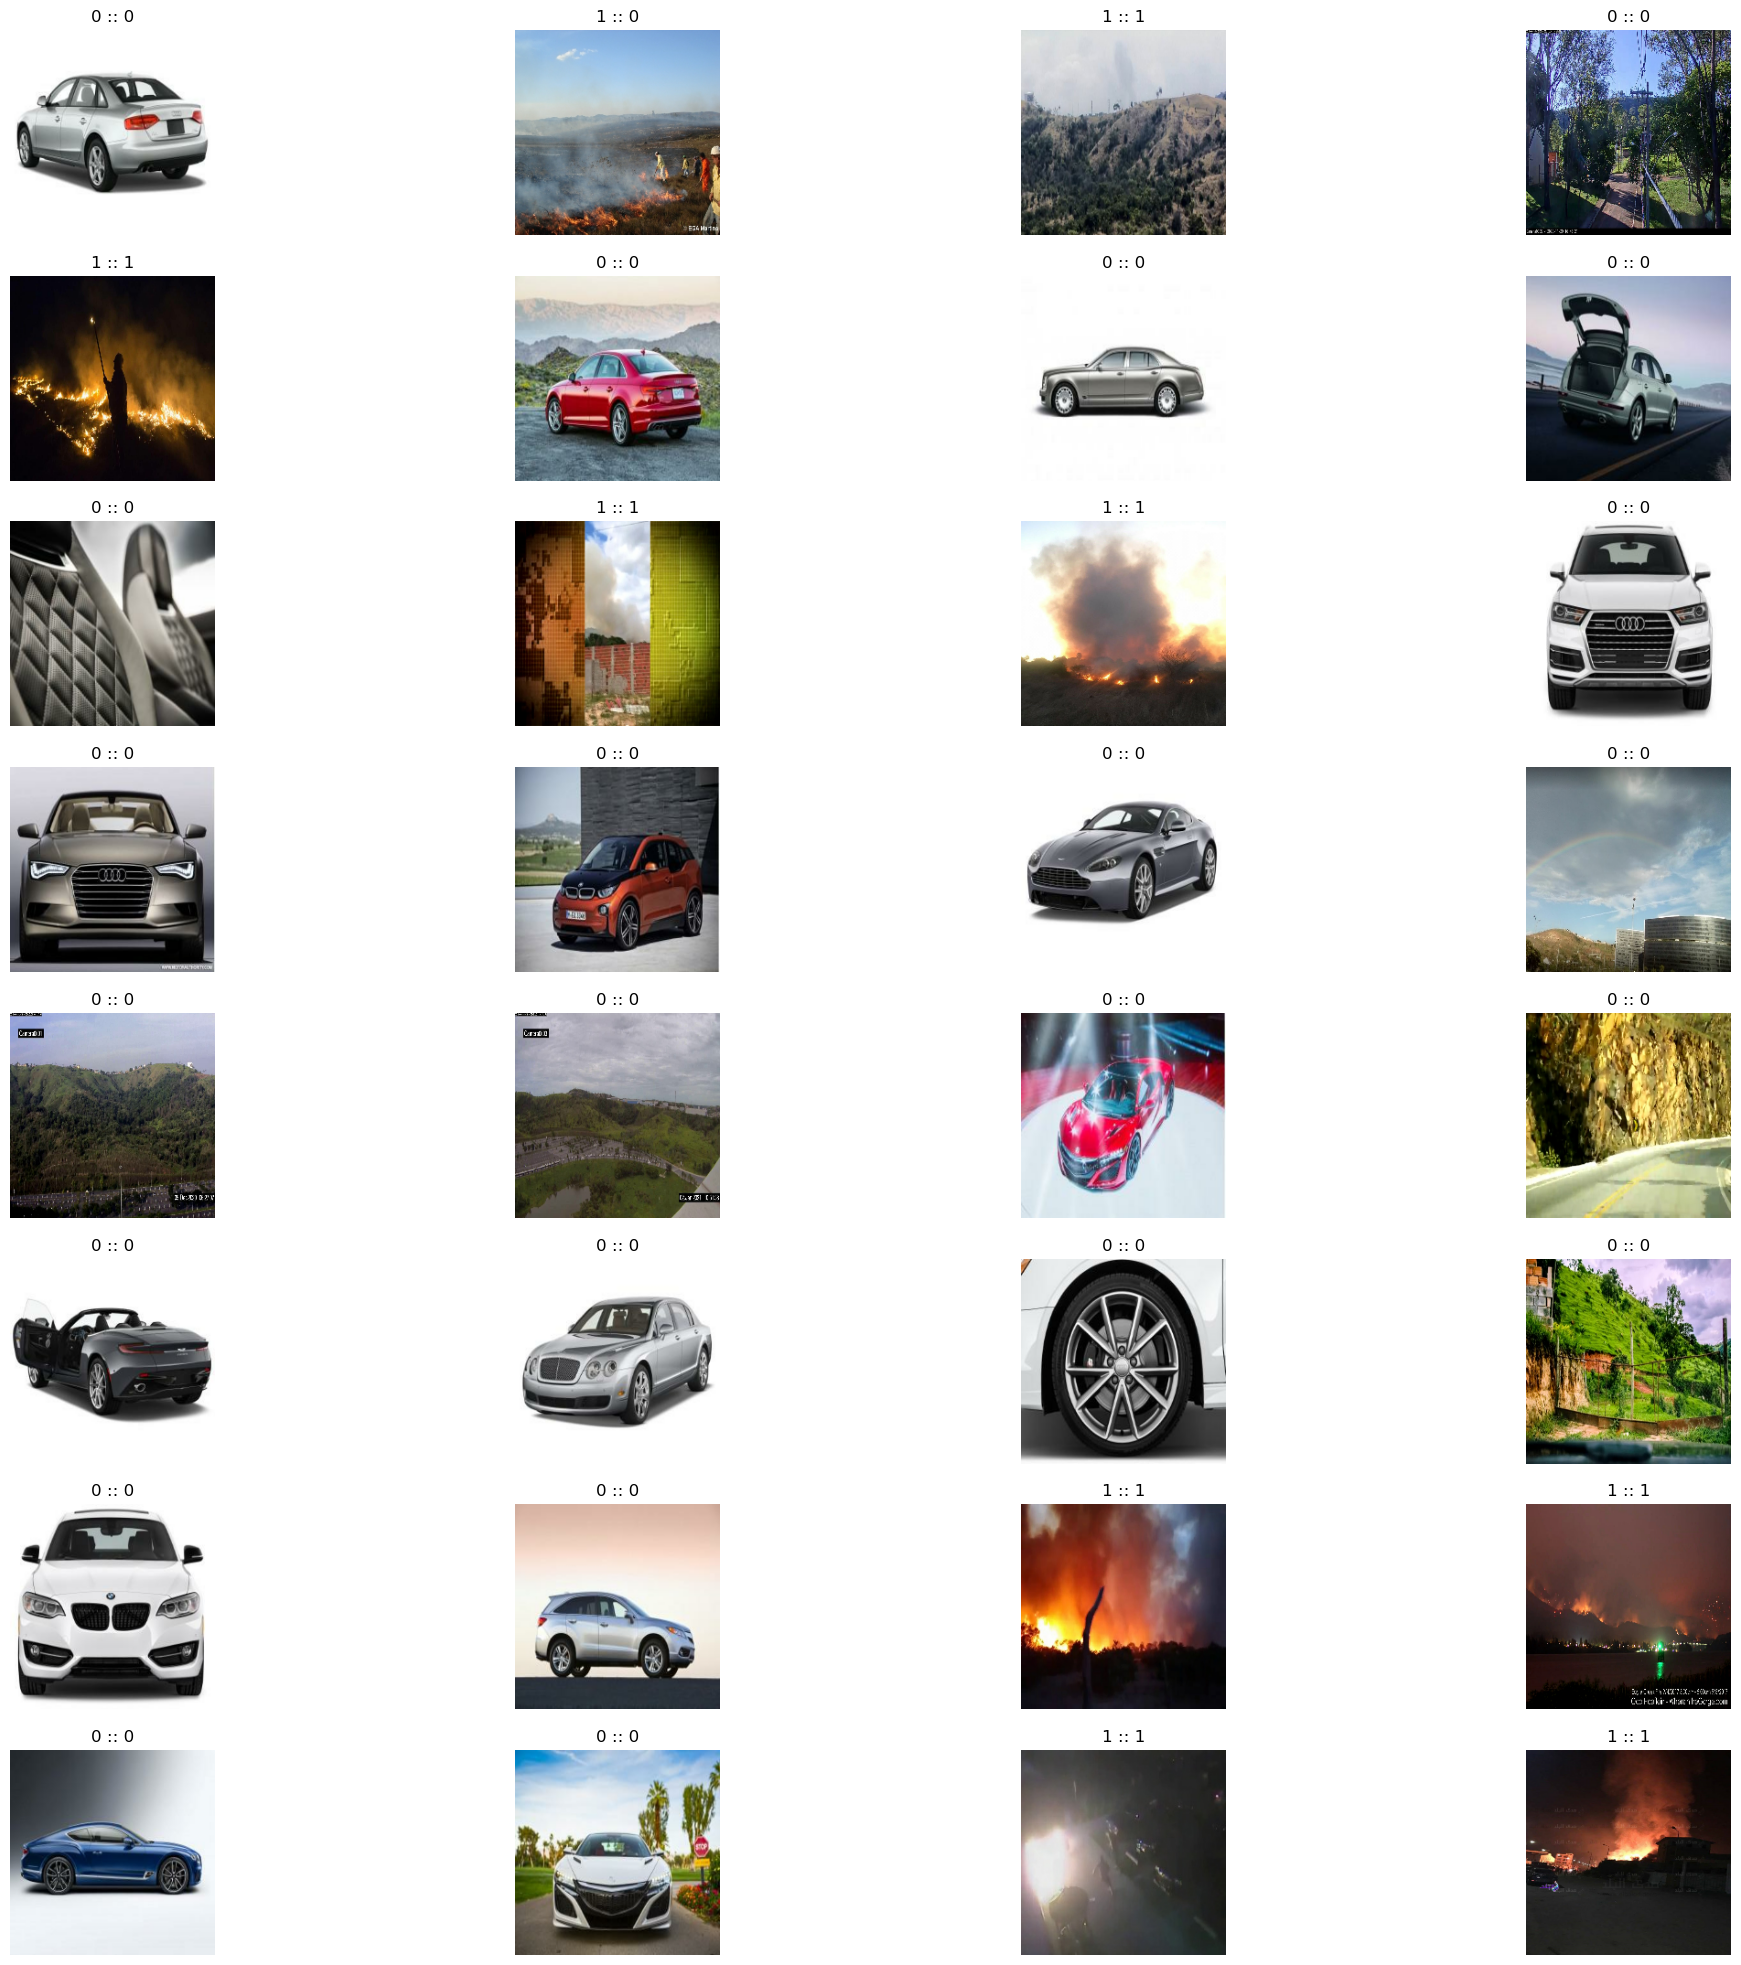

In [26]:
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i][0]]}')
    plt.axis("off")

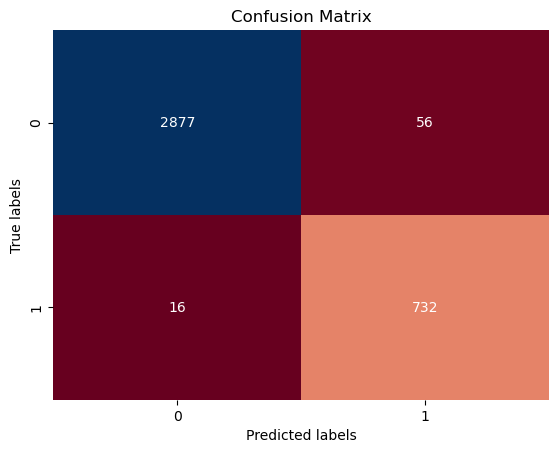

array([[2877,   56],
       [  16,  732]], dtype=int64)

In [27]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()
CM

In [28]:
ClassificationReport = classification_report(y_val,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.99      0.98      0.99      2933
           1       0.93      0.98      0.95       748

    accuracy                           0.98      3681
   macro avg       0.96      0.98      0.97      3681
weighted avg       0.98      0.98      0.98      3681



In [65]:
def Test(path):
    model = keras.models.load_model('/kaggle/working/final_model.h5')
    class_names = ['non_fire_images', 'fire_images']
    
    for img in os.listdir(path):
        image = cv2.imread(os.path.join(path, img))
        image = cv2.resize(image, (224,224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.expand_dims(image, axis=0)
        
        predict = model.predict(image)
        pred_class = np.where(predict >= 0.5, 1, 0)
        
        plt.figure(figsize=(25, 25))
        plt.imshow(image.astype("uint8"))
        plt.title(f'{class_names[pred_class[0][0]]}')
        plt.axis("off")
        plt.show()